In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


def calc_price(phi, lambd, wtp):
    phi = np.array(phi)
    n = len(phi)
    price = np.array([0]*n)
    if n == 1:
        price = np.array([wtp - lambd])
    elif n == 2:
        p0 = (2 * phi[0] + phi[1]) / 3 + lambd
        p1 = (2 * phi[1] + phi[0]) / 3 + lambd
        price = np.array([p0, p1])
    elif n == 3:
        A = np.eye(n)
        for i in range(n):
            A[i, (i-1) % n] -= 0.5
            A[i, (i+1) % n] -= 0.5
        b = np.zeros(n)
        for i in range(n):
            b[i] = phi[i] - 0.5 * (phi[(i-1) % n] + phi[(i+1) % n]) + lambd
        price = np.linalg.solve(A, b)
    else:
        raise NotImplementedError("Only supports n=1, 2, or 3 (with asymmetry).")
    
    # Final check and simple outlier handling
    if np.any(phi < 0) or np.any(phi > wtp) or np.any(price < 0) or np.any(price > wtp):
        return np.zeros(n)
    return price


def calc_s(phi, cost, wtp):
    phi = np.array(phi)
    n = len(phi)
    if n == 1:
        return np.array([1.])
    prices = calc_price(phi, cost, wtp)
    # If all prices are zero, bad state
    if np.all(prices == 0):
        return np.zeros(n)
    s = np.zeros(n)
    if n == 2:
        p1, p2 = prices
        s1 = 0.5 + (p2 - p1) / (2 * cost)
        s[:] = [s1, 1 - s1]
    else:
        circumference = 1.0
        for i in range(n):
            left = (i-1) % n
            right = (i+1) % n
            arc = circumference / n
            delta_p_left = prices[i] - prices[left]
            z_left = (delta_p_left / (2*cost)) + (arc/2)
            delta_p_right = prices[right] - prices[i]
            z_right = (delta_p_right / (2*cost)) + (arc/2)
            s[i] = z_left + z_right
        s *= (circumference / np.sum(s))  # normalize

    # Final check for out-of-bounds: if any share out of [0,1], zero all shares
    if np.any(s < 0) or np.any(s > 1):
        return np.zeros(n)
    return s

def calc_profits(phi, cost, wtp, mc):
    s = calc_s(phi, cost, wtp)
    prices = calc_price(phi, cost, wtp)
    hospital_profit = np.sum(s * (phi - mc))
    insurer_profits = s * (prices - phi)
    return hospital_profit, insurer_profits, s, prices


def analytic_phi(cost, wtp, n, belief="active"):
    if n==0:
        return 0
    if n == 1:
        return (wtp - cost) / 2
    elif n == 2:
        if belief == "active":
            return 0.75*cost + (wtp-cost)/2
        elif belief == "passive":
            return 1.5*cost
    elif n == 3:
        if belief == "active":
            return 0.75*cost + (wtp-cost)/2
        elif belief == "passive":
            return 1.5*cost
    return None




def nash_obj_helper(phi_vec, cost, wtp, mc, betas, disagreement=0):
    hospital_profit, insurer_profits, s, prices = calc_profits(phi_vec, cost, wtp, mc)
    print(phi_vec, s, disagreement, hospital_profit, prices, insurer_profits)
    if hospital_profit - disagreement <= 1e-8 or insurer_profits[0] <= 1e-8 or hospital_profit <= 1e-8 :
        return 10
    obj = np.log(hospital_profit - disagreement) * (1 - betas[0]) + np.log(insurer_profits[0]) * betas[0]
    return -obj


#TODO nash objective actually depends on the thing we're optimzing over e.g. dphi1/dphi2 = 0... 
def passive_disagreement(phi_vec, cost, wtp, mc):

    s = calc_s(phi_vec, cost,wtp)
    phi = np.array(phi_vec)
    mc = np.array(mc)
    # Disagreement: hospital gets only business with OTHER insurers
    return np.sum(s*(phi-mc)) - s[0]*(phi[0]-mc[0])


def recursive_disagreement(phi_vec, cost, wtp, mc, betas, analytic_base=True):
    n = len(phi_vec)
    if analytic_base and n <= 2:
        # For 1- or 2-firm base: use all analytic phi (active beliefs by default here)
        sub_phi = np.array([analytic_phi(cost, wtp, n-1, belief='active')] * n)
        hospital_profit, _, _, _ = calc_profits(sub_phi, cost, wtp, mc[:n])
        return hospital_profit
    if n == 1:
        # (should never reach here if analytic_base is True... but as fallback)
        phi_init = [analytic_phi(cost, wtp, 1, belief='active')]
        result = minimize(lambda phi: nash_obj(phi, cost, wtp, [mc[0]], [betas[0]]),
                          phi_init, method='Nelder-Mead', options={'disp': False})
        phi_star = result.x
        hosp_profit, _, _, _ = calc_profits(phi_star, cost, wtp, [mc[0]])
        return hosp_profit
    # n-1 agents: recursively solve Nash for subgame (all but the first)
    keep = list(range(1, n))
    phi_sub = np.array([phi_vec[j] for j in keep])
    mc_sub = np.array([mc[j] for j in keep])
    betas_sub = [betas[j] for j in keep]
    phi_sub_sol = solve_nash(phi_sub, cost, wtp, mc_sub, betas_sub, active=active, analytic_base=analytic_base)
    hospital_profit, _, _, _ = calc_profits(phi_sub_sol, cost, wtp, mc_sub)
    return hospital_profit


def nash_obj(phi_vec, cost, wtp, mc, betas, active=True,analytic_base=True,phi_tmp_prev=0):
    disagreement = 0
    n = len(phi_vec)
    if n == 1:
        return disagreement
    if active:
        disagreement = recursive_disagreement(phi_vec, cost, wtp, mc, betas, analytic_base=analytic_base)
    else:
        phi_vec_tmp  = phi_vec.copy()
        phi_vec_tmp[0] = phi_tmp_prev #keep the current firm phi fixed...
        disagreement = passive_disagreement(phi_vec_tmp, cost, wtp, mc)

    return nash_obj_helper(phi_vec, cost, wtp, mc, betas, disagreement)


def solve_nash(phi_init, cost, wtp, mc, betas=None, active=False, maxiter=100, tol=1e-7, verbose=False):
    """
    Contraction mapping for n-firm Nash-in-Nash bargaining.
    phi_init: initial guess vector
    mc, betas are vectors
    """
    n = len(phi_init)
    if betas is None:
        betas = [0.5] * n
    phi = np.array(phi_init, dtype=float)
    phi_prev = phi.copy()

    for it in range(maxiter):
        phi_prev[:] = phi[:]
        for k in range(n):
            # Minimize over a SCALAR phi_k, holding all other phi fixed.
            def helper(phi_k_scalar):
                phi_tmp  = phi_prev.copy()
                phi_tmp_prev = phi_tmp[0]#phi_prev[k].copy()
                phi_tmp[k] = phi_k_scalar[0]  # phi_k_scalar is a 1-element array/lst
                # Roll so agent k is in 0 position for nash_obj
                phi_tmp_roll = np.roll(phi_tmp, -k)
                mc_roll = np.roll(mc, -k)
                betas_roll = np.roll(betas, -k)
                if active:
                    return nash_obj(phi_tmp_roll, cost, wtp, mc_roll, betas_roll,active=True)
                else:
                    return nash_obj(phi_tmp_roll, cost, wtp, mc_roll, betas_roll,active=False,
                                    phi_tmp_prev=phi_tmp_prev) #likely need to have 2 objectives...
            res = minimize(helper, [phi[k]], method='Nelder-Mead', options={'disp': False})
            phi[k] = res.x[0]
        diff = np.max(np.abs(phi - phi_prev))
        phi_prev = phi.copy()

        if verbose:
            print(f"Iter {it}, phi={phi}, diff={diff}")
        if diff < tol:
            break
    return phi

In [2]:



print(calc_s([20,15], 5,25))

[0.33333333 0.66666667]


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- Model run/prints ---
COST = 5
WTP = 25
MC = np.array([0, 0, 0])
betas = [0.5, 0.5, 0.5]
betas2 = [0.5, 0.5]

DO_THREE_FIRM = False  # Set this to True to enable 3-firm case

for n in [1, 2] + ([3] if DO_THREE_FIRM else []):
    print(f"\n{'='*10}\nN={n}")
    if n==1:
        phi = np.array([analytic_phi(COST, WTP, 1)])
        print("1-firm analytic φ:", phi)
        hospital_profit, insurer_profits, s, prices = calc_profits(phi, COST, WTP, np.zeros(n))
        print("1-firm, hospital profit:", hospital_profit, "insurer:", insurer_profits, "shares:", s, "prices:", prices)
    else:
        phi_init_act = [analytic_phi(COST, WTP, n, belief='active')]*n
        phi_init_pass = [analytic_phi(COST, WTP, n, belief='passive')]*n
        phi_passive = solve_nash(phi_init_pass, COST, WTP, np.zeros(n), [0.5]*n, active=False)
        print("PASSIVE φ:", phi_passive)
        hospital_profit, insurer_profits, s, prices = calc_profits(phi_passive, COST, WTP, np.zeros(n))
        print("   hospital profit:", hospital_profit, "insurers:", insurer_profits, "shares:", s, "prices:", prices)
        phi_active = solve_nash(phi_init_act, COST, WTP, np.zeros(n), [0.5]*n, active=True)
        print("ACTIVE φ:", phi_active)
        hospital_profit_a, insurer_profits_a, s_a, prices_a = calc_profits(phi_active, COST, WTP, np.zeros(n))
        print("   hospital profit:", hospital_profit_a, "insurers:", insurer_profits_a, "shares:", s_a, "prices:", prices_a)
        print("Analytic φ (active):", analytic_phi(COST, WTP, n, "active"))
        print("Analytic φ (passive):", analytic_phi(COST, WTP, n, "passive"))


N=1
1-firm analytic φ: [10.]
1-firm, hospital profit: 10.0 insurer: [10.] shares: [1.] prices: [20]

N=2
[7.5 7.5] [0.5 0.5] 3.75 7.5 [12.5 12.5] [2.5 2.5]
[7.875 7.5  ] [0.4875 0.5125] 3.75 7.682812499999999 [12.75  12.625] [2.3765625 2.6265625]
[7.125 7.5  ] [0.5125 0.4875] 3.75 7.307812500000001 [12.25  12.375] [2.6265625 2.3765625]
[7.6875 7.5   ] [0.49375 0.50625] 3.75 7.592578125 [12.625  12.5625] [2.43789063 2.56289063]
[7.3125 7.5   ] [0.50625 0.49375] 3.75 7.405078124999999 [12.375  12.4375] [2.56289063 2.43789063]
[7.59375 7.5    ] [0.496875 0.503125] 3.75 7.546582031250001 [12.5625  12.53125] [2.46884766 2.53134766]
[7.40625 7.5    ] [0.503125 0.496875] 3.75 7.45283203125 [12.4375  12.46875] [2.53134766 2.46884766]
[7.546875 7.5     ] [0.4984375 0.5015625] 3.75 7.523364257812499 [12.53125  12.515625] [2.48439941 2.51564941]
[7.453125 7.5     ] [0.5015625 0.4984375] 3.75 7.4764892578125 [12.46875  12.484375] [2.51564941 2.48439941]
[7.5234375 7.5      ] [0.49921875 0.5007812

[1.  7.5] [0.71666667 0.28333333] 1.875 2.8416666666666677 [ 8.16666667 10.33333333] [5.13611111 0.80277778]
[ 1.   13.75] [0.925 0.075] 10.0 1.9562499999999994 [10.25 14.5 ] [8.55625 0.05625]
[1.08026756 7.5       ] [0.71399108 0.28600892] 1.875 2.916368291928128 [ 8.22017837 10.36008919] [5.09783264 0.81801102]
[ 1.08026756 13.75      ] [0.92232441 0.07767559] 10.0 2.0643964413149747 [10.30351171 14.52675585] [8.50682326 0.06033497]
[1.16053512 7.5       ] [0.7113155 0.2886845] 1.875 2.990640391792784 [ 8.27369008 10.38684504] [5.05969735 0.83338743]
[ 1.16053512 13.75      ] [0.91964883 0.08035117] 10.0 2.1721133572331404 [10.35702341 14.55351171] [8.45753969 0.06456311]
[1.24080268 7.5       ] [0.70863991 0.29136009] 1.875 3.0644829662606305 [ 8.32720178 10.41360089] [5.02170523 0.84890702]
[ 1.24080268 13.75      ] [0.91697324 0.08302676] 10.0 2.279400747754499 [10.41053512 14.58026756] [8.4083993  0.06893442]
[1.32107023 7.5       ] [0.70596433 0.29403567] 1.875 3.137896015331670

[5.57525084 7.5       ] [0.56415831 0.43584169] 1.875 6.414136773265027 [11.21683389 11.85841695] [3.18274594 1.89957983]
[ 5.57525084 13.75      ] [0.77249164 0.22750836] 10.0 7.435074621648527 [13.30016722 16.02508361] [5.96743332 0.51760054]
[5.65551839 7.5       ] [0.56148272 0.43851728] 1.875 6.464355450908453 [11.2703456 11.8851728] [3.15262845 1.92297405]
[ 5.65551839 13.75      ] [0.76981605 0.23018395] 10.0 7.518738115345464 [13.35367893 16.05183946] [5.92616756 0.52984649]
[5.73578595 7.5       ] [0.55880713 0.44119287] 1.875 6.5141446031550725 [11.3238573  11.91192865] [3.12265414 1.94651144]
[ 5.73578595 13.75      ] [0.76714047 0.23285953] 10.0 7.601972083645599 [13.40719064 16.07859532] [5.88504498 0.54223562]
[5.81605351 7.5       ] [0.55613155 0.44386845] 1.875 6.5635042300048845 [11.37736901 11.9386845 ] [3.092823   1.97019201]
[ 5.81605351 13.75      ] [0.76446488 0.23553512] 10.0 7.684776526548921 [13.46070234 16.10535117] [5.84406557 0.55476791]
[5.89632107 7.5     

[15.1270903  7.5      ] [0.24576366 0.75423634] 1.875 9.374461601846365 [17.58472687 15.04236343] [0.60399775 5.68872462]
[15.1270903 13.75     ] [0.45409699 0.54590301] 10.0 14.375332560597759 [19.6680602 19.2090301] [2.06204076 2.98010096]
[15.20735786  7.5       ] [0.24308807 0.75691193] 1.875 9.37356675726968 [17.63823857 15.06911929] [0.5909181  5.72915668]
[15.20735786 13.75      ] [0.4514214 0.5485786] 10.0 14.407882532074584 [19.72157191 19.23578595] [2.03781285 3.00938475]
[15.28762542  7.5       ] [0.24041249 0.75958751] 1.875 9.372242387296192 [17.69175028 15.09587514] [0.57798163 5.76973191]
[15.28762542 13.75      ] [0.44874582 0.55125418] 10.0 14.440002978154608 [19.77508361 19.26254181] [2.0137281  3.03881172]
[15.36789298  7.5       ] [0.2377369 0.7622631] 1.875 9.37048849192589 [17.74526198 15.12263099] [0.56518834 5.81045032]
[15.36789298 13.75      ] [0.44607023 0.55392977] 10.0 14.471693898837824 [19.82859532 19.28929766] [1.98978654 3.06838186]
[15.44816054  7.5   

[19.22073579  7.5       ] [0.10930881 0.89069119] 1.875 8.78117964750581 [20.31382386 16.40691193] [0.11948415 7.93330801]
[19.22073579 13.75      ] [0.31764214 0.68235786] 10.0 15.487736224986298 [22.39715719 20.5735786 ] [1.00896529 4.65612248]
[19.30100334  7.5       ] [0.10663322 0.89336678] 1.875 8.758379007691929 [20.36733556 16.43366778] [0.11370644 7.981042  ]
[19.30100334 13.75      ] [0.31496656 0.68503344] 10.0 15.498380401225937 [22.4506689  20.60033445] [0.99203931 4.69270821]
[19.3812709  7.5      ] [0.10395764 0.89604236] 1.875 8.735148842481255 [20.42084727 16.46042363] [0.1080719  8.02891917]
[19.3812709 13.75     ] [0.31229097 0.68770903] 10.0 15.508595052068767 [22.5041806 20.6270903] [0.9752565 4.7294371]
[19.46153846  7.5       ] [0.10128205 0.89871795] 1.875 8.711489151873765 [20.47435897 16.48717949] [0.10258054 8.07693951]
[19.46153846 13.75      ] [0.30961538 0.69038462] 10.0 15.518380177514791 [22.55769231 20.65384615] [0.95861686 4.76630917]
[19.54180602  7.5

[23.0735786 13.75     ] [0.18921405 0.81078595] 10.0 15.514152036889968 [24.96571906 21.85785953] [0.35801956 6.57373862]
[23.15384615  7.5       ] [0. 0.] 1.875 0.0 [22.93589744 17.71794872] [-0.  0.]
[23.15384615 13.75      ] [0. 0.] 10.0 0.0 [0. 0.] [-0. -0.]
[23.23411371  7.5       ] [0. 0.] 1.875 0.0 [22.98940914 17.74470457] [-0.  0.]
[23.23411371 13.75      ] [0. 0.] 10.0 0.0 [0. 0.] [-0. -0.]
[23.31438127  7.5       ] [0. 0.] 1.875 0.0 [23.04292085 17.77146042] [-0.  0.]
[23.31438127 13.75      ] [0. 0.] 10.0 0.0 [0. 0.] [-0. -0.]
[23.39464883  7.5       ] [0. 0.] 1.875 0.0 [23.09643255 17.79821628] [-0.  0.]
[23.39464883 13.75      ] [0. 0.] 10.0 0.0 [0. 0.] [-0. -0.]
[23.47491639  7.5       ] [0. 0.] 1.875 0.0 [23.14994426 17.82497213] [-0.  0.]
[23.47491639 13.75      ] [0. 0.] 10.0 0.0 [0. 0.] [-0. -0.]
[23.55518395  7.5       ] [0. 0.] 1.875 0.0 [23.20345596 17.85172798] [-0.  0.]
[23.55518395 13.75      ] [0. 0.] 10.0 0.0 [0. 0.] [-0. -0.]
[23.63545151  7.5       ] [0. 0.

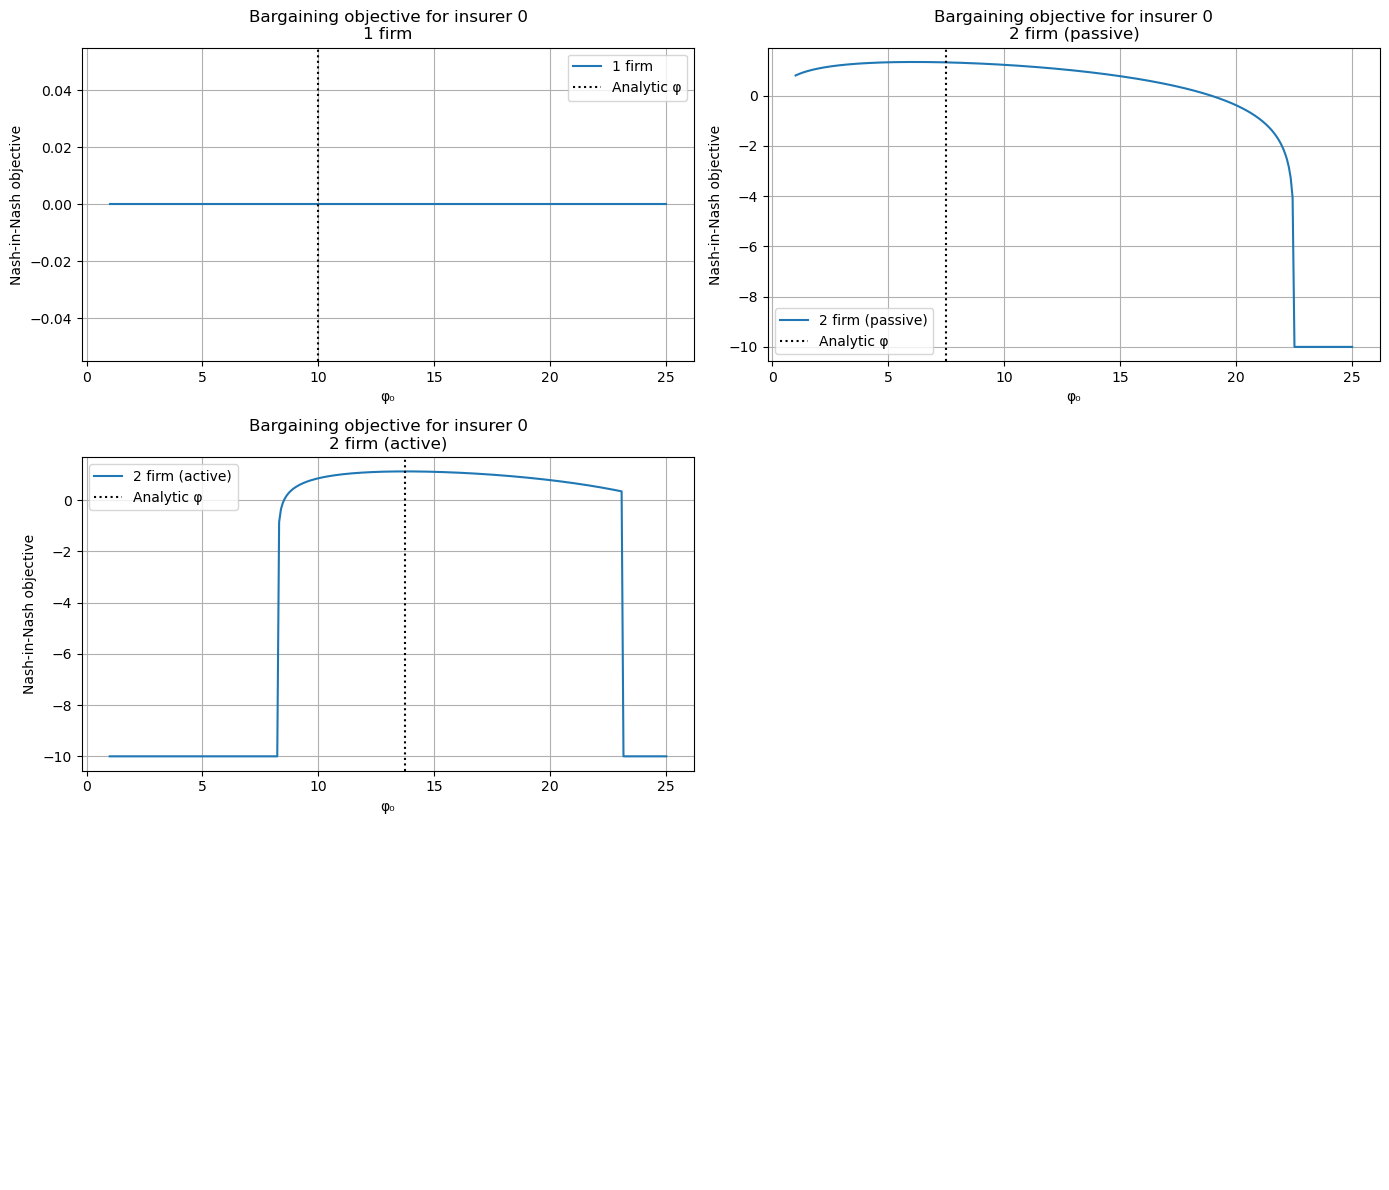

In [4]:


# --- For plotting, set the other φ's to analytic solution for their scenario ---
phis_grid = np.linspace(1, WTP, 300)
objective_plots = {}

# 1-firm
n = 1
obj_1 = []
for phi0 in phis_grid:
    pvec = np.array([phi0])
    o = nash_obj(pvec, COST, WTP, np.zeros(n), [0.5])
    obj_1.append(-o)
objective_plots['1-firm'] = obj_1

# 2-firm
n = 2
phi2_passive = analytic_phi(COST, WTP, 2, "passive")
phi2_active = analytic_phi(COST, WTP, 2, "active")
obj_2_pass = []
obj_2_active = []
for phi0 in phis_grid:
    pvec_pass = np.array([phi0, phi2_passive])
    o2p = nash_obj(pvec_pass, COST, WTP, np.zeros(n), betas2,active=False)
    obj_2_pass.append(-o2p)
    pvec_act = np.array([phi0, phi2_active])
    o2a = nash_obj(pvec_act, COST, WTP, np.zeros(n), betas2,active=True)
    obj_2_active.append(-o2a)
objective_plots['2-firm-passive'] = obj_2_pass
objective_plots['2-firm-active'] = obj_2_active

if DO_THREE_FIRM:
    # 3-firm
    n = 3
    phi23_passive = analytic_phi(COST, WTP, 3, "passive")
    phi23_active = analytic_phi(COST, WTP, 3, "active")
    obj_3_pass = []
    obj_3_active = []
    for phi0 in phis_grid:
        pvec_pass = np.array([phi0, phi23_passive, phi23_passive])
        o3p = nash_obj(pvec_pass, COST, WTP, np.zeros(n), betas,active=False)
        obj_3_pass.append(-o3p)
        pvec_act = np.array([phi0, phi23_active, phi23_active])
        o3a = nash_obj(pvec_act, COST, WTP, np.zeros(n), betas,active=True)
        obj_3_active.append(-o3a)
    objective_plots['3-firm-passive'] = obj_3_pass
    objective_plots['3-firm-active'] = obj_3_active

# ------ Plotting ------
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
plt.subplots_adjust(hspace=0.3)
analytic_vals = {
    '1-firm': analytic_phi(COST, WTP, 1),
    '2-firm-active': analytic_phi(COST, WTP, 2, "active"),
    '2-firm-passive': analytic_phi(COST, WTP, 2, "passive"),
}
if DO_THREE_FIRM:
    analytic_vals.update({
        '3-firm-active': analytic_phi(COST, WTP, 3, "active"),
        '3-firm-passive': analytic_phi(COST, WTP, 3, "passive"),
    })
plot_names = [
    ('1-firm', 0, 0, '1 firm'),
    ('2-firm-passive', 0, 1, '2 firm (passive)'),
    ('2-firm-active', 1, 0, '2 firm (active)'),
]
if DO_THREE_FIRM:
    plot_names.extend([
        ('3-firm-passive', 1, 1, '3 firm (passive)'),
        ('3-firm-active', 2, 0, '3 firm (active)')
    ])

for name, row, col, pretty in plot_names:
    ax = axs[row, col]
    y = objective_plots[name]
    ax.plot(phis_grid, y, label=pretty)
    if analytic_vals.get(name) is not None:
        ax.axvline(analytic_vals[name], color='k', ls=':', label="Analytic φ")
    ax.set_title(f"Bargaining objective for insurer 0\n{pretty}")
    ax.set_xlabel('φ₀')
    ax.set_ylabel('Nash-in-Nash objective')
    ax.legend()
    ax.grid()

if DO_THREE_FIRM:
    axs[2, 1].axis('off')
else:
    axs[1, 1].axis('off')
    axs[2, 0].axis('off')
    axs[2, 1].axis('off')
plt.tight_layout()
plt.show()